# import data

In [2]:
import scanpy as sc 
import scvi

/home/ak/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_hip.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0
/home/ak/miniconda3/envs/py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/ak/miniconda3/envs/py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero

In [ ]:
#import pandas as pd
#ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
#ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
#ribo_genes

In [2]:
import pandas as pd
ribo_genes = pd.read_table('ribo_genes.txt',skiprows=2, header=None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [3]:
def pp(csv_path):
    adata = sc.read_csv(csv_path).T
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]

    return adata

In [ ]:
import os
out = []
for file in os.listdir('rawdata_test/'):
    out.append(pp('rawdata_test/' + file))

In [ ]:
os.listdir('rawdata_test/')

In [ ]:
out[0]

In [ ]:
adata = sc.concat(out)

In [ ]:
sc.pp.filter_genes(adata, min_cells=10)
adata

In [ ]:
# 稀疏矩阵转化
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)

In [ ]:
adata.obs.groupby('Sample').count()

In [ ]:
# 保存未标准化的counts
adata.layers['counts']=adata.X.copy()

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [ ]:
# sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset = True, layer = 'counts',
#                            flavor = "seurat_v3", batch_key="Sample") #no batch_key if one sample

# Integrate

In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [ ]:
model = scvi.model.SCVI(adata)

In [ ]:
model.train() #may take a while without GPU

In [ ]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [ ]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [ ]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [ ]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.6)

In [ ]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

In [ ]:
adata.write_h5ad('integrated.h5ad')

# Find markers/ label cell types

In [ ]:
sc.tl.leiden(adata, resolution = 1) 

In [ ]:
adata.layers[' scvi_normalized']

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden') #使用保存的raw，而不是经scvi处理后的数据

In [ ]:
#sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [ ]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

In [ ]:
markers_scvi = model.differential_expression(groupby = 'leiden') #使用scvi计算marker genes
markers_scvi

In [ ]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi

In [ ]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

In [ ]:
# 生成字典
for i in range(0,16):
    print(f'"{i}":"",')

In [5]:
cell_type = {
    "0":"AT1",
"1":"CD4+T",
"2":"",
"3":"AT2",
"4":"CD8+T",
"5":"Fibroblasts",
"6":"",
"7":"",
"8":"Macrophages",
"9":"",
"10":"Airway epithelial cells",
"11":"",
"12":"",
"13":"",
"14":"",
"15":""
    }

In [ ]:
#根据目的细胞分群，调整聚类分辨率resolution
sc.pl.umap(adata, color = ['PTPRC', 'SFTPC', 'SFTPA1'], frameon = False, layer = 'scvi_normalized', vmax = 10) 
#, layer = 'scvi_normalized'，标准化之后一般会使颜色差异缩小
# vmax 设置颜色对比度

In [ ]:
# 表格查找特定marker
markers[markers.names == 'CD4']

In [ ]:
markers[markers.group=='5']

In [6]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_type)

/home/ak/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


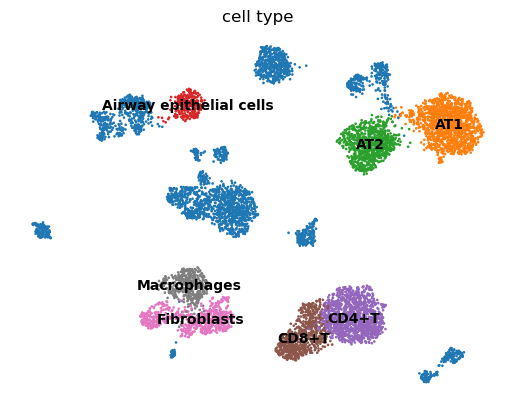

In [7]:
sc.pl.umap(adata, color = ['cell type'], frameon = False,legend_loc = "on data" )

In [ ]:
adata

In [ ]:
adata.uns['scvi_markers'] = markers_scvi
adata.uns['markers'] = markers

In [ ]:
adata.write_h5ad('integrated.h5ad')

In [ ]:
model.save('model.model')

# Analysis

In [4]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Counting cells

In [5]:
adata = sc.read_h5ad('../integrated.h5ad')

In [8]:
type(adata.obs.doublet)

pandas.core.series.Series

In [ ]:
adata.obs.Sample.unique().tolist()

In [ ]:
def map_condition(x):
    if 'cov' in x:
        return 'COVID19'
    else:
        return 'control'

In [ ]:
adata.obs['condition'] = adata.obs.Sample.map(map_condition)
adata.obs

In [ ]:
num_tot_cells = adata.obs.groupby(['Sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.doublet))
num_tot_cells

In [ ]:
cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
cell_type_counts

In [ ]:
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(num_tot_cells).astype(int)

cell_type_counts['frequency'] = cell_type_counts.doublet / cell_type_counts.total_cells

cell_type_counts

In [ ]:
plt.figure(figsize = (10,4))

ax = sns.boxplot(data = cell_type_counts, x = 'cell type', y = 'frequency', hue = 'condition')

plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')

plt.show()

## DE

In [11]:

subset = adata[adata.obs['cell type'].isin(['CD4+T', 'CD8+T'])].copy()

### DE with diffxpy

In [ ]:
import diffxpy.api as de

In [ ]:
subset.X = subset.X.toarray()

In [ ]:
len(subset.var)

In [ ]:
subset

In [ ]:
sc.pp.filter_genes(subset, min_cells=100)

In [ ]:
len(subset.var)

In [ ]:
subset.obs = subset.obs.rename(columns = {'cell type':'cell_type'})

In [ ]:
#subset = subset.raw.to_adata() #need to run this if you scaled/regress your data and have negative numbers

In [ ]:
subset.obs

In [ ]:
#if want to test between covid/non covid
# res = de.test.wald(data=subset,
#              formula_loc= '~ 1 + condition',
#              factor_loc_totest='condition'
#                   )


res = de.test.wald(data=subset,
             formula_loc= '~ 1 + cell_type',
             factor_loc_totest='cell_type'
                  )

In [ ]:
dedf = res.summary().sort_values('log2fc', ascending = False).reset_index(drop = True)
dedf

In [ ]:
subset.obs.cell_type.unique()

In [ ]:
most_up = dedf.iloc[0].gene
i = np.where(subset.var_names == most_up)[0][0]

a = subset[subset.obs.cell_type == 'AT1'].X[:, i]
b = subset[subset.obs.cell_type == 'AT2'].X[:, i]
print(f"{most_up} expression:")
print(f"AT1: {a.mean()}")
print(f"AT2: {b.mean()}")

In [ ]:
dedf['log2fc'] = dedf['log2fc']*-1
dedf = dedf.sort_values('log2fc', ascending = False).reset_index(drop = True)
dedf

In [ ]:
dedf = dedf[(dedf.qval < 0.05) & (abs(dedf.log2fc) > .5)]
dedf

In [ ]:
dedf = dedf[dedf['mean'] > 0.15]
dedf

In [ ]:
genes_to_show = dedf[-25:].gene.tolist() + dedf[:25].gene.tolist() #top 25 and bottom 25 from sorted df

In [ ]:
sc.pl.heatmap(subset, genes_to_show, groupby='cell_type', swap_axes=True)

### DE with scvi

In [ ]:
model  = scvi.model.SCVI.load('model.model', adata)
model

In [ ]:
scvi_de = model.differential_expression(
    idx1 = [adata.obs['cell type'] == 'AT1'],
    idx2 = [adata.obs['cell type'] == 'AT2']
    )

#any set of cells vs any set of cells
# scvi_de = model.differential_expression(
#     idx1 = [(adata.obs['cell type'].isin(['AT1', 'AT2'])) & (adata.obs.condition == 'COVID19')],
#     idx2 = [(adata.obs['cell type'].isin(['AT1', 'AT2'])) & (adata.obs.condition == 'control')]
#     )

In [ ]:
scvi_de

In [ ]:
scvi_de = scvi_de[(scvi_de['is_de_fdr_0.05']) & (abs(scvi_de.lfc_mean) > .5)]
scvi_de = scvi_de.sort_values('lfc_mean')
scvi_de

In [ ]:
scvi_de = scvi_de[(scvi_de.raw_normalized_mean1 > .5) | (scvi_de.raw_normalized_mean2 > .5)]
scvi_de

In [ ]:
genes_to_show = scvi_de[-25:].index.tolist() + scvi_de[:25].index.tolist() #top 25 and bottom 25 from sorted df

In [ ]:
sc.pl.heatmap(subset, genes_to_show, groupby='cell_type', swap_axes=True, 
              layer = 'scvi_normalized',
              log = True)

#################################################################################################

/home/ak/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


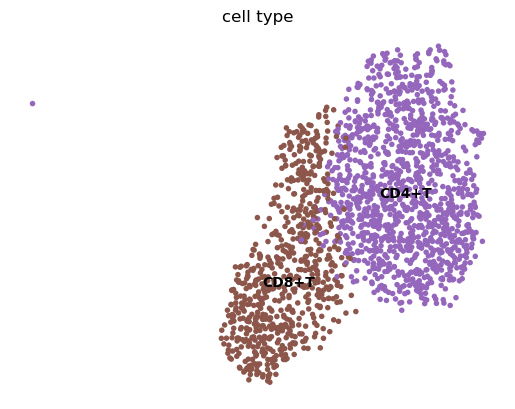

In [12]:
sc.pl.umap(subset, color = ['cell type'], frameon = False,legend_loc = "on data" )

In [17]:
sc.pp.neighbors(subset, use_rep = 'X_scVI')
sc.tl.umap(subset)
sc.tl.leiden(subset, resolution = 0.5)

/home/ak/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


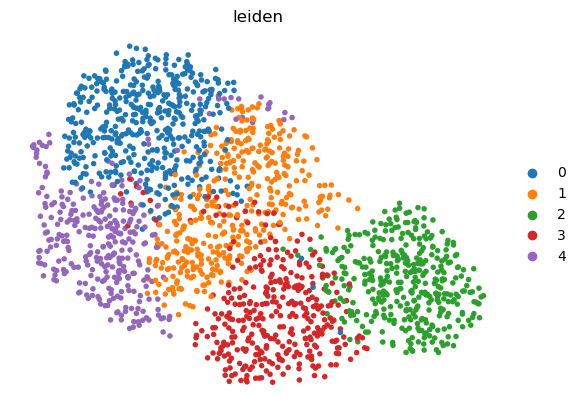

In [22]:
sc.tl.leiden(subset, resolution = 0.5)
sc.pl.umap(subset, color = ['leiden'], frameon = False#,legend_loc = "on data"
          )

In [23]:
markers = sc.get.rank_genes_groups_df(subset, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,NCKAP5,125.445816,8.104198,0.000000,0.000000
1,0,EMP2,95.304314,7.532261,0.000000,0.000000
2,0,LMO7,93.035217,6.213637,0.000000,0.000000
3,0,NEDD4L,86.431107,5.282877,0.000000,0.000000
4,0,LIMCH1,79.541954,4.626924,0.000000,0.000000
...,...,...,...,...,...,...
302682,15,CARD11,2.227902,1.532444,0.032374,0.048649
302683,15,AIDA,2.226140,2.412066,0.032524,0.048868
302684,15,SLC2A3,2.225595,1.812722,0.032556,0.048912
302685,15,GPBP1,2.221091,1.433473,0.032884,0.049393


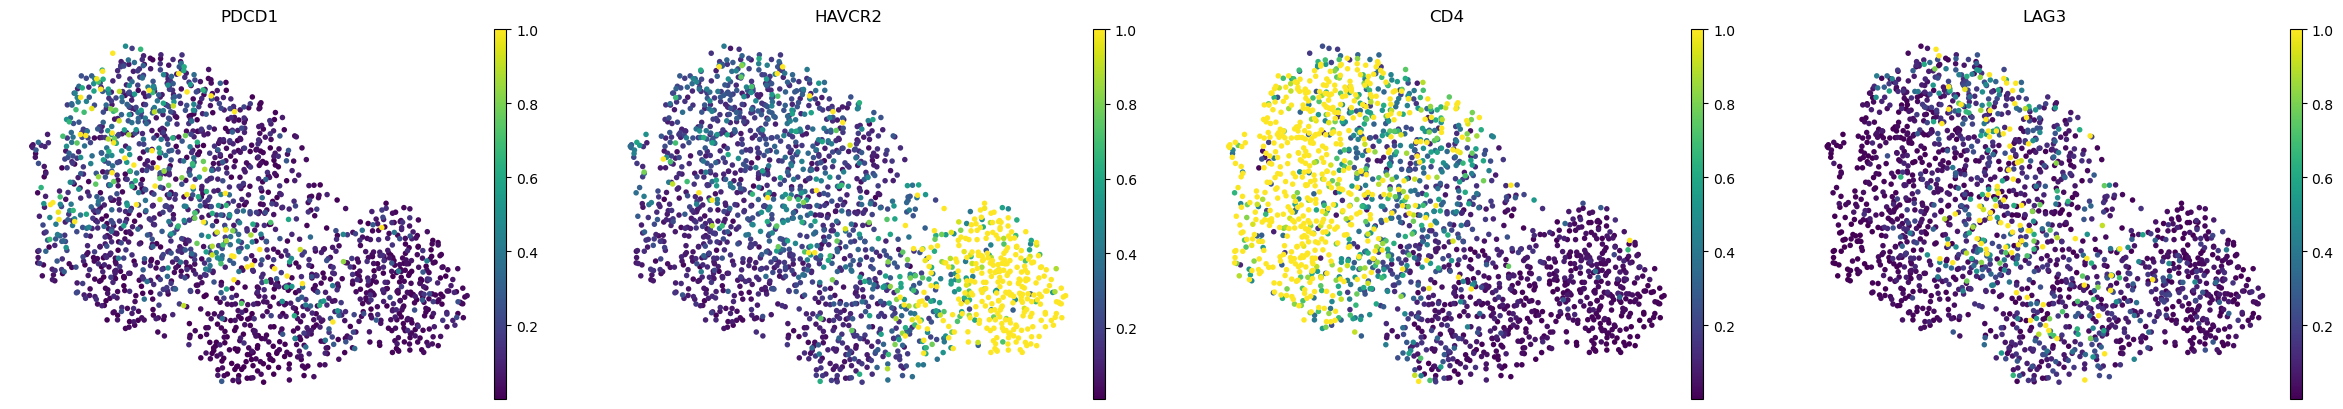

In [29]:
sc.pl.umap(subset, color = ['PDCD1','HAVCR2','CD4','LAG3'], frameon = False, layer = 'scvi_normalized', vmax = 1)